## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "None"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95


In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
    
def combined_loss(ce_w, gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        cat_CE = keras.losses.categorical_crossentropy(y_true, y_pred)
        
        
        return tf.reduce_mean(reduced_fl) * (1-ce_w) + cat_CE * ce_w
    
    return focal_loss_fixed


ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))
    
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (B

Epoch 46/50
50000/50000 [==============================] - 7s 145us/step - loss: 0.1159 - accuracy: 0.9884 - val_loss: 6.2256 - val_accuracy: 0.4821
Epoch 47/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.1039 - accuracy: 0.9904 - val_loss: 6.3313 - val_accuracy: 0.4749
Epoch 48/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.0943 - accuracy: 0.9917 - val_loss: 6.2986 - val_accuracy: 0.4880
Epoch 49/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.0870 - accuracy: 0.9931 - val_loss: 6.4247 - val_accuracy: 0.4691
Epoch 50/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.0768 - accuracy: 0.9942 - val_loss: 6.4797 - val_accuracy: 0.4754
Numbers of exp: 1, ce_weight: 0.30
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_____

Epoch 41/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.3125 - accuracy: 0.9511 - val_loss: 4.5469 - val_accuracy: 0.4841
Epoch 42/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.2865 - accuracy: 0.9562 - val_loss: 4.4624 - val_accuracy: 0.4821
Epoch 43/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.2642 - accuracy: 0.9619 - val_loss: 4.6544 - val_accuracy: 0.4810
Epoch 44/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.2430 - accuracy: 0.9666 - val_loss: 4.6313 - val_accuracy: 0.4918
Epoch 45/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.2295 - accuracy: 0.9699 - val_loss: 4.7555 - val_accuracy: 0.4847
Epoch 46/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.2081 - accuracy: 0.9742 - val_loss: 4.7550 - val_accuracy: 0.4848
Epoch 47/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.1914 - accuracy: 0.9777

Epoch 36/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.5505 - accuracy: 0.8927 - val_loss: 3.3960 - val_accuracy: 0.4851
Epoch 37/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.5206 - accuracy: 0.8998 - val_loss: 3.4615 - val_accuracy: 0.4782
Epoch 38/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.4850 - accuracy: 0.9101 - val_loss: 3.5278 - val_accuracy: 0.4782
Epoch 39/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.4508 - accuracy: 0.9185 - val_loss: 3.5640 - val_accuracy: 0.4839
Epoch 40/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.4213 - accuracy: 0.9247 - val_loss: 3.7045 - val_accuracy: 0.4727
Epoch 41/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.3932 - accuracy: 0.9317 - val_loss: 3.6684 - val_accuracy: 0.4815
Epoch 42/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.3683 - accuracy: 0.9390

Epoch 31/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.8030 - accuracy: 0.8149 - val_loss: 2.4742 - val_accuracy: 0.4957
Epoch 32/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.7646 - accuracy: 0.8234 - val_loss: 2.4635 - val_accuracy: 0.4936
Epoch 33/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.7291 - accuracy: 0.8365 - val_loss: 2.5321 - val_accuracy: 0.4848
Epoch 34/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.6902 - accuracy: 0.8464 - val_loss: 2.5468 - val_accuracy: 0.4863
Epoch 35/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.6599 - accuracy: 0.8533 - val_loss: 2.5465 - val_accuracy: 0.4925
Epoch 36/50
50000/50000 [==============================] - 7s 144us/step - loss: 0.6260 - accuracy: 0.8629 - val_loss: 2.6081 - val_accuracy: 0.4890
Epoch 37/50
50000/50000 [==============================] - 7s 144us/step - loss: 0.5957 - accuracy: 0.8722

Epoch 26/50
50000/50000 [==============================] - 8s 165us/step - loss: 0.9338 - accuracy: 0.6890 - val_loss: 1.4508 - val_accuracy: 0.4985
Epoch 27/50
50000/50000 [==============================] - 8s 164us/step - loss: 0.9144 - accuracy: 0.6973 - val_loss: 1.4620 - val_accuracy: 0.4985
Epoch 28/50
50000/50000 [==============================] - 11s 214us/step - loss: 0.8955 - accuracy: 0.7035 - val_loss: 1.4679 - val_accuracy: 0.4938
Epoch 29/50
50000/50000 [==============================] - 12s 240us/step - loss: 0.8770 - accuracy: 0.7121 - val_loss: 1.4693 - val_accuracy: 0.4996
Epoch 30/50
50000/50000 [==============================] - 9s 177us/step - loss: 0.8559 - accuracy: 0.7193 - val_loss: 1.4789 - val_accuracy: 0.4945
Epoch 31/50
50000/50000 [==============================] - 11s 211us/step - loss: 0.8377 - accuracy: 0.7273 - val_loss: 1.4816 - val_accuracy: 0.4922
Epoch 32/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.8187 - accuracy: 0.

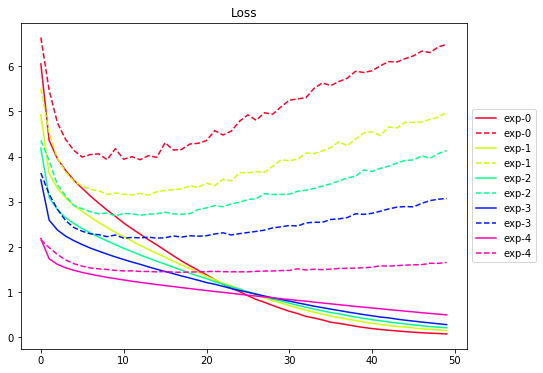

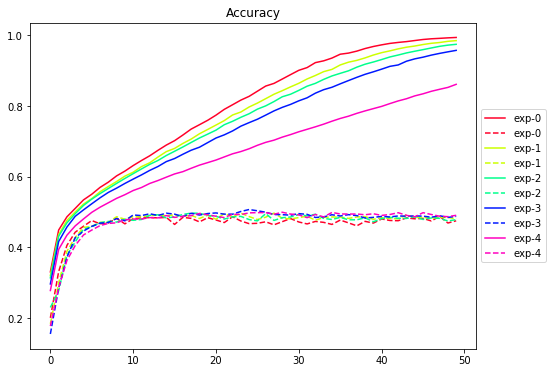

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()